In [41]:
'''
Beginning implementation of "Motion without movement" illusions
'''

import cv2
from PIL import Image
import matplotlib.pylab as plt
import os
import numpy as np 
import imageio
from skimage.exposure import rescale_intensity
from math import exp, cos, sin
from scipy.ndimage import gaussian_filter, laplace, gaussian_laplace
from tqdm import tqdm 
from pathlib import Path
from scipy.signal import hilbert, convolve
import math
import shutil 
from scipy.ndimage import filters


In [16]:
def make_gif(img_paths, gif_path, fps):
    # from: https://github.com/tuananhle7/continuous_mws/blob/master/cmws/util.py 
    Path(gif_path).parent.mkdir(parents=True, exist_ok=True)
    images = []
    for img_path in tqdm(img_paths):
        images.append(imageio.imread(img_path))
    imageio.mimsave(gif_path, images, duration=1 / fps)

def second_deriv_gauss(x,y,theta=0): 
    # G_2^theta = k_a(theta)*G_2a + k_b(theta)*G_2b + k_c(theta)*G_2c
    # values from Table 1 (p. 29)
    
    G_2a = 0.9213 * (2*(x**2) - 1)*exp(-(x**2 + y**2))
    G_2b = 1.843 * x * y * exp(-(x**2 + y**2))
    G_2c = 0.9213*(2*(y**2) - 1)*exp(-(x**2 + y**2))
    
    k_a = cos(theta) ** 2 
    k_b = -2*cos(theta) * sin(theta)
    k_c = sin(theta)**2
    
    return k_a * G_2a + k_b * G_2b + k_c * G_2c   

def custom_hilbert(x,y,theta=0): 
    # values from Table 3 (p. 30)
    
    H_2a = 0.9780*(-2.254*x + x**3)*exp(-(x**2 + y**2))
    H_2b = 0.9780*(-0.7515 + x**2)*exp(-(x**2 + y**2))
    H_2c = 0.9780*(-0.7515 + y**2)*exp(-(x**2 + y**2))
    H_2d = 0.9780*(-2.254*y + y**3)*exp(-(x**2 + y**2))
    
    k_a = cos(theta) ** 3 
    k_b = -3*(cos(theta)**2)*sin(theta)
    k_c  = 3*(sin(theta)**2)*cos(theta)
    k_d = -sin(theta) ** 3 
    
    return k_a * H_2a + k_b * H_2b + k_c * H_2c + k_d * H_2d
    

Img Shape: (392, 504)


(-0.5, 503.5, 391.5, -0.5)

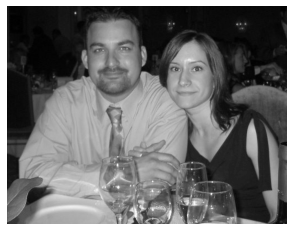

In [3]:
# load in image to be transformed and convert to grayscale
# help from: https://stackoverflow.com/questions/60050816/converting-rgb-to-grayscale-python

img_pth = "./couple.jpg"

# convert to grayscale 
img = Image.open(img_pth).convert('LA') 
img = np.asarray(img)[:,:,0]

print(f"Img Shape: {np.shape(img)}")

cmap='gray'
plt.imshow(img, cmap=cmap)
plt.axis('off')

(-0.5, 503.5, 391.5, -0.5)

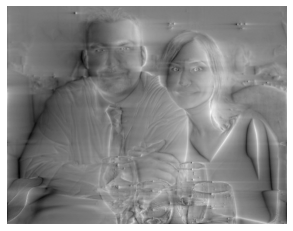

In [4]:
transf_img =  np.imag(hilbert(img)) # help from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html

plt.imshow(transf_img, cmap=cmap)
plt.axis('off')

(-0.5, 503.5, 391.5, -0.5)

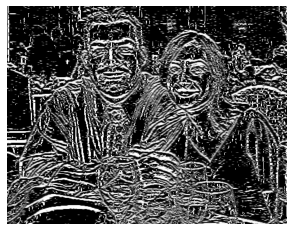

In [164]:
sigma=1.0
transf_img =  gaussian_laplace(img, sigma=sigma) # help from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html

plt.imshow(transf_img, cmap=cmap)
plt.axis('off')

In [165]:
# def create_filter(filter_func, filter_size, theta): 
#     # filter_func is a function that takes as input x,y,theta
#     sample_filter = []
#     for x in range(filter_size):
#         filt_vals = []
#         for y in range(filter_size):
#             filt_val = filter_func(x,y,theta)
#             filt_vals.append(filt_val)
#         sample_filter.append(filt_vals)
#     sample_filter = np.array(sample_filter) 
#     return sample_filter 

def create_filter(filter_func, filter_size, theta): 
    # filter_func is a function that takes as input x,y,theta
    sample_filter = []
    vals = np.linspace(0,1, filter_size)
    for x in vals:
        filt_vals = []
        for y in vals:
            filt_val = filter_func(x,y,theta)
            filt_vals.append(filt_val)
        sample_filter.append(filt_vals)
    sample_filter = np.array(sample_filter) 
    return sample_filter 

size = 3
theta = 1.0
omega = 0.5
t = 1

# eq 3: 
E = cv2.filter2D(img, -1, create_filter(second_deriv_gauss, size, theta))#, mode="same")
E = gaussian_laplace(img, sigma=theta)

# eq 4: 
O = cv2.filter2D(img, -1, create_filter(custom_hilbert, size, theta))#, mode = "same")

# eq 5:
D = cos(omega*t)*E + sin(omega*t)*O

(-0.5, 503.5, 391.5, -0.5)

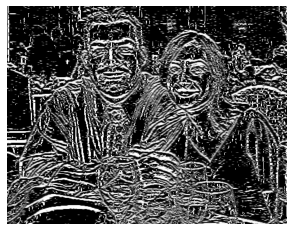

In [166]:
plt.imshow(E, cmap="gray")
plt.axis('off')

(-0.5, 503.5, 391.5, -0.5)

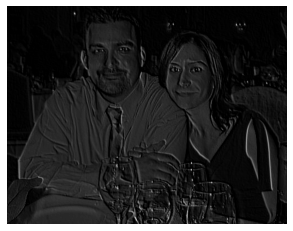

In [167]:
plt.imshow(O, cmap="gray")
plt.axis('off')

(-0.5, 503.5, 391.5, -0.5)

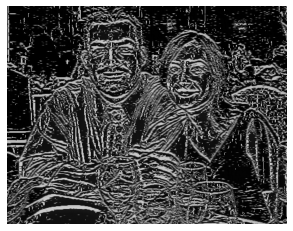

In [168]:
plt.imshow(D, cmap="gray")
plt.axis('off')

In [ ]:
save_dir = "./sample_illusion"

if os.path.isdir(save_dir): shutil.rmtree(save_dir)
os.makedirs(save_dir)

omega = 2.0
num_steps = 100
cycle_len = math.pi
for t in np.linspace(0,cycle_len, num_steps): #range(num_steps): 
    transf_img = cos(omega*t)*E + sin(omega*t)*O 
    plt.imshow(transf_img, cmap=cmap)
    plt.axis('off')
    plt.savefig(f"{save_dir}/{t}.png")
    
gif_path = f"{save_dir}/illusion_gif.gif"
imgs = [f"{save_dir}/{img}" for img in os.listdir(save_dir) if img[-4:] == ".png"]

make_gif(imgs, gif_path, 10)

In [ ]:
save_dir = "./sample_illusion_simple"

if os.path.isdir(save_dir): shutil.rmtree(save_dir)
os.makedirs(save_dir)

omega = 1
num_steps = 100
sigma = 0.56#0.3
cmap="gray"
cycle_len = math.pi #*2 
# for t in np.linspace(0,cycle_len, num_steps): 
for t in np.linspace(cycle_len/2,cycle_len, num_steps): 
    transf_img = cos(omega * t) * gaussian_laplace(img, sigma=sigma) + sin(omega * t) * np.imag(hilbert(img)) 
    plt.imshow(transf_img, cmap=cmap)
    plt.axis('off')
    plt.savefig(f"{save_dir}/{t}.png")
    
gif_path = f"{save_dir}/illusion_gif.gif"
imgs = [f"{save_dir}/{img}" for img in os.listdir(save_dir) if img[-4:] == ".png"]

make_gif(imgs, gif_path, 3)

In [213]:
gif_path = f"{save_dir}/illusion_gif.gif"
imgs = [f"{save_dir}/{img}" for img in os.listdir(save_dir) if img[-4:] == ".png"]

make_gif(imgs, gif_path, 5)

100%|██████████| 100/100 [00:00<00:00, 314.03it/s]


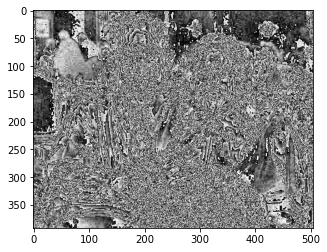

In [185]:
plt.imshow(gaussian_laplace(img, sigma=sigma), cmap=cmap)

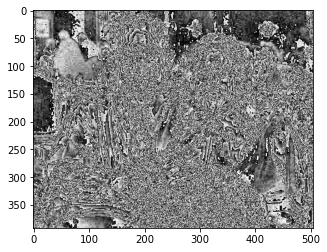

In [190]:
omega = 0.3
t = 0
plt.imshow(cos(omega * 0) * gaussian_laplace(img, sigma=sigma), cmap="gray")

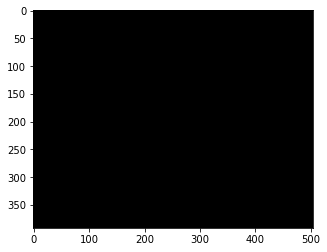

In [191]:
plt.imshow(sin(omega * t) * np.imag(hilbert(img)),cmap="gray")

In [199]:
np.max(sin(omega * t) * np.imag(hilbert(img))), np.max(cos(omega * 0) * gaussian_laplace(img, sigma=sigma))

(-0.0, 255.0)

In [200]:
transf_img = cos(omega * t) * gaussian_laplace(img, sigma=sigma) + sin(omega * t) * np.imag(hilbert(img)) 
np.min(transf_img), np.max(transf_img)

(0.0, 255.0)

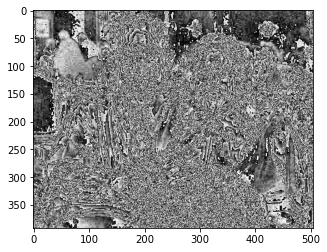

In [201]:
plt.imshow(transf_img,cmap="gray")